[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 16462, number of used features: 7
[LightGBM] [Info] Start training from score 516074.124043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

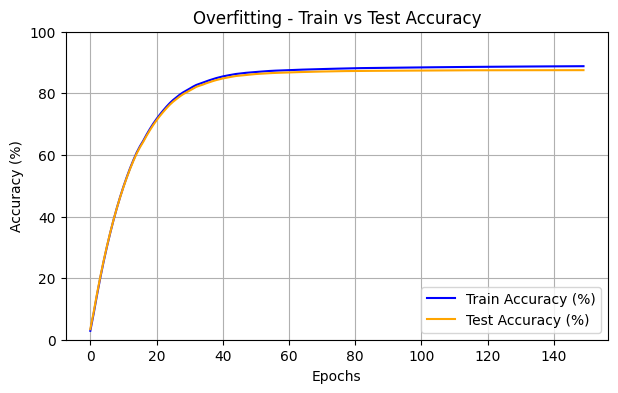

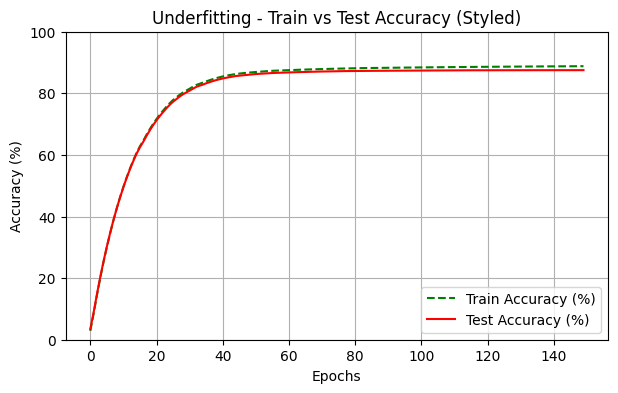

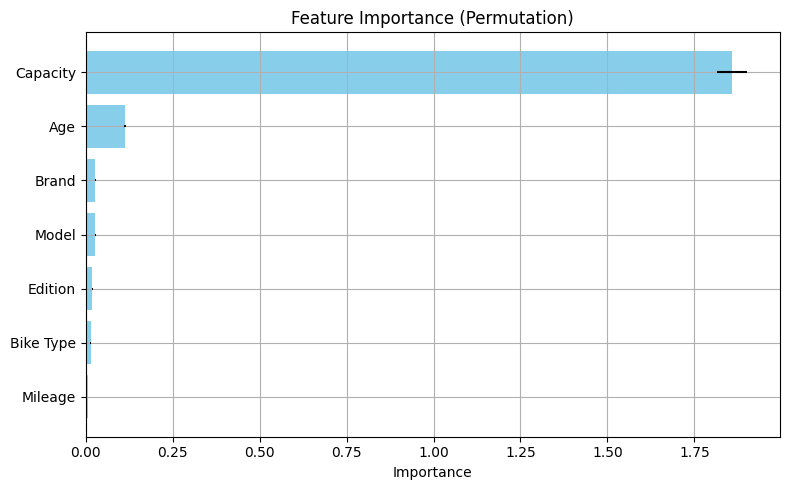


Model Summary & Performance Metrics
--------------------------------------------------
XGBoost Regressor:
  MAE:       Rs 23,429
  MSE:       Rs 4,067,940,352
  RMSE:      Rs 63,780
  R² Score:  0.9854
  Accuracy:  95.82%
--------------------------------------------------
LightGBM Regressor:
  MAE:       Rs 21,460
  MSE:       Rs 3,953,985,843
  RMSE:      Rs 62,881
  R² Score:  0.9858
  Accuracy:  96.73%
--------------------------------------------------
Stacked Ensemble Regressor:
  MAE:       Rs 19,469
  MSE:       Rs 3,765,190,912
  RMSE:      Rs 61,361
  R² Score:  0.9865
  Accuracy:  97.66%
--------------------------------------------------


['ensemble_model.joblib']

In [20]:
# Import Libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
import warnings
from numpy import log1p
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMRegressor
warnings.filterwarnings("ignore")

# Load and Clean Dataset
df = pd.read_csv("used-bikes.csv")
df = df.drop_duplicates().dropna()

# Clean numeric columns (remove Rs, km, cc and commas)
for col, symbol in [('Price', 'Rs'), ('Mileage', 'km'), ('Capacity', 'cc')]:
    df[col] = df[col].astype(str).str.replace(symbol, "", regex=False).str.replace(",", "", regex=False).str.strip().astype(int)

# Feature Engineering
df['YearGap'] = pd.Timestamp.now().year - df['Year']
df['Age'] = log1p(df['YearGap'])
df['Mileage'] = np.log1p(df['Mileage'])

# Encode Categorical Features
encoders = {}
for col in ['Bike Type', 'Brand', 'Edition', 'Model']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Save Label Encoders
with open("label_encoders.json", "w") as f:
    json.dump({k: {str(k1): int(v1) for k1, v1 in v.items()} for k, v in encoders.items()}, f)

# Define Features and Target
X = df[['Bike Type', 'Brand', 'Edition', 'Model', 'Age', 'Mileage', 'Capacity']]
y = df['Price']

# Train/Test Split (first!)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save Scaler
joblib.dump(scaler, "scaler.joblib")

# Train XGBoost Regressor
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    learning_rate=0.07,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=5,
    reg_lambda=10,
    random_state=42
)

xgb_base.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

lgbm_base = LGBMRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    random_state=42
)

lgbm_base.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_metric='rmse',
)

# Evaluation Graphs
results = xgb_base.evals_result()
epochs = len(results['validation_0']['rmse'])

mean_y_train = np.mean(y_train)
mean_y_test = np.mean(y_test)

train_accuracy = [100 - (rmse / mean_y_train) * 100 for rmse in results['validation_0']['rmse']]
test_accuracy = [100 - (rmse / mean_y_test) * 100 for rmse in results['validation_1']['rmse']]

# Evaluate XGBoost
y_pred_xgb = xgb_base.predict(X_test_scaled)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
acc_xgb = 100 - np.mean(np.abs((y_test - y_pred_xgb) / y_test)) * 100

# Evaluate LightGBM
y_pred_lgbm = lgbm_base.predict(X_test_scaled)
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
acc_lgbm = 100 - np.mean(np.abs((y_test - y_pred_lgbm) / y_test)) * 100

# XGBoost
xgb_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_search = GridSearchCV(xgb_model, xgb_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_search.fit(X_train_scaled, y_train)
xgb_best = xgb_search.best_estimator_

# LightGBM
lgbm_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [15, 31]
}
lgbm_model = LGBMRegressor(random_state=42)
lgbm_search = GridSearchCV(lgbm_model, lgbm_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
lgbm_search.fit(X_train_scaled, y_train)
lgbm_best = lgbm_search.best_estimator_

# Random Forest
rf_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
rf_model = RandomForestRegressor(random_state=42)
rf_search = GridSearchCV(rf_model, rf_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_search.fit(X_train_scaled, y_train)
rf_best = rf_search.best_estimator_

# --- 2. Stacked Ensemble ---
stacked_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_best),
        ('lgbm', lgbm_best),
        ('rf', rf_best)
    ],
    final_estimator=xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42),
    passthrough=True,
    cv=5
)

stacked_model.fit(X_train_scaled, y_train)
joblib.dump(stacked_model, "ensemble_model.joblib")

# Evaluate Ensemble
y_pred_ens = stacked_model.predict(X_test_scaled)
mae_ens = mean_absolute_error(y_test, y_pred_ens)
mse_ens = mean_squared_error(y_test, y_pred_ens)
rmse_ens = np.sqrt(mse_ens)
r2_ens = r2_score(y_test, y_pred_ens)
acc_ens = 100 - np.mean(np.abs((y_test - y_pred_ens) / y_test)) * 100

# Plot Graphs
plt.figure(figsize=(7, 4))
plt.plot(range(epochs), train_accuracy, label='Train Accuracy (%)', color='blue')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy (%)', color='orange')
plt.title("Overfitting - Train vs Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(range(epochs), train_accuracy, label='Train Accuracy (%)', linestyle='--', color='green')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy (%)', linestyle='-', color='red')
plt.title("Underfitting - Train vs Test Accuracy (Styled)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

importances = permutation_importance(stacked_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
sorted_idx = importances.importances_mean.argsort()[::-1]
feature_names = X.columns

# Plot Feature Importance
plt.figure(figsize=(8, 5))
plt.barh(range(len(sorted_idx)), importances.importances_mean[sorted_idx], xerr=importances.importances_std[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Permutation)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary
print("\nModel Summary & Performance Metrics")
print("-" * 50)
print("XGBoost Regressor:")
print(f"  MAE:       Rs {mae_xgb:,.0f}")
print(f"  MSE:       Rs {mse_xgb:,.0f}")
print(f"  RMSE:      Rs {rmse_xgb:,.0f}")
print(f"  R² Score:  {r2_xgb:.4f}")
print(f"  Accuracy:  {acc_xgb:.2f}%")
print("-" * 50)
print("LightGBM Regressor:")
print(f"  MAE:       Rs {mae_lgbm:,.0f}")
print(f"  MSE:       Rs {mse_lgbm:,.0f}")
print(f"  RMSE:      Rs {rmse_lgbm:,.0f}")
print(f"  R² Score:  {r2_lgbm:.4f}")
print(f"  Accuracy:  {acc_lgbm:.2f}%")
print("-" * 50)
print("Stacked Ensemble Regressor:")
print(f"  MAE:       Rs {mae_ens:,.0f}")
print(f"  MSE:       Rs {mse_ens:,.0f}")
print(f"  RMSE:      Rs {rmse_ens:,.0f}")
print(f"  R² Score:  {r2_ens:.4f}")
print(f"  Accuracy:  {acc_ens:.2f}%")
print("-" * 50)

# Save Models
xgb_base.get_booster().save_model("xgb_model.json")
joblib.dump(stacked_model, "ensemble_model.joblib")

In [21]:
import joblib
import json
import numpy as np
import pandas as pd

# Load saved model and preprocessing artifacts
model = joblib.load("ensemble_model.joblib")
scaler = joblib.load("scaler.joblib")

with open("label_encoders.json", "r") as f:
    label_encoders = json.load(f)

# Sample input dictionary (adjust values as needed)


input_data = {
    "Bike Type": "Motorbikes",
    "Brand": "KTM",
    "Edition": "Standard",
    "Model": "Duke 790",
    "Year": 2024,
    "Mileage": 19631,
    "Capacity": 799
}

# Encode categorical features using label encoders
encoded = []
for feature in ["Bike Type", "Brand", "Edition", "Model"]:
    val = input_data.get(feature, "")
    encoder = label_encoders.get(feature, {})
    encoded_val = encoder.get(val, 0)
    encoded.append(encoded_val)

# Add derived feature 'Age'
age = pd.Timestamp.now().year - input_data["Year"]
encoded += [age, input_data["Mileage"], input_data["Capacity"]]

# Convert to numpy array and scale
X_input = np.array([encoded])
X_scaled = scaler.transform(X_input)

# Predict price
predicted_price = model.predict(X_scaled)[0]
print(f"Predicted Price: Rs {predicted_price:,.0f}")

Predicted Price: Rs 2,379,832
